### Monte Carlo Algorithm for finding interaction coefficients for randomly generated 2D lattice

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
e_x = 10*(np.random.rand(2)*2 -1)
e_y = 10*(np.random.rand(2)*2 -1)

In [12]:
num_qubits=8
initial_eta = (np.random.rand(num_qubits - 1)*2 - 1)

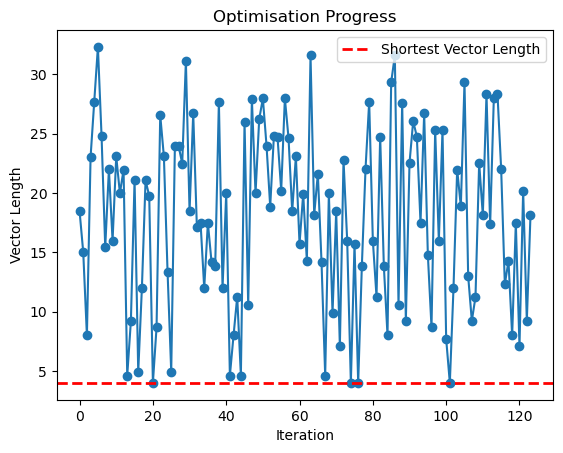

Optimised eta coefficients: [-0.65670568 -1.1269143  -1.69821089  1.38354989  0.16243625 -0.19333439
  0.6525333 ]
Shortest vector length: 3.994538130433819


In [13]:
def pauli_z():
    return np.array([[1, 0], [0, -1]])

def identity():
    return np.eye(2)

def tensor_product(operators):
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def construct_hamiltonian(num_qubits, coefficients, mu):
    H = np.zeros((2**num_qubits, 2**num_qubits))
    for i, coeff in enumerate(coefficients):
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        if i + 1 < num_qubits:  
            ops[i + 1] = pauli_z()
        H += coeff * tensor_product(ops)
    
    for i in range(num_qubits-1):  
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        H += mu * tensor_product(ops)
    
    return H

def compute_eigenvalues_and_eigenvectors(H):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def order_eigenvectors_by_energy(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def decode_eigenvector_signed_magnitude(index, num_bits_per_coordinate):
    binary_str = format(index, f'0{2 * num_bits_per_coordinate}b')
    x_bin = binary_str[:num_bits_per_coordinate]
    y_bin = binary_str[num_bits_per_coordinate:]
    
    def signed_magnitude_decode(bin_str):
        sign = int(bin_str[0])
        magnitude = int(bin_str[1:], 2)
        return magnitude if sign == 0 else -magnitude
    
    x = signed_magnitude_decode(x_bin)
    y = signed_magnitude_decode(y_bin)
    
    return (x, y)

def calculate_vector_length(decoded_coordinates, e_x, e_y):
    a, b = decoded_coordinates
    v = a * e_x + b * e_y
    return np.linalg.norm(v)

def find_shortest_vector(e_x, e_y, range_limit):
    shortest_length = float('inf')
    shortest_vector = None
    best_a = best_b = None

    for a in range(-range_limit, range_limit + 1):
        for b in range(-range_limit, range_limit + 1):
            if a == 0 and b == 0:
                continue  # skip the zero vector
            v = a * e_x + b * e_y
            length = np.linalg.norm(v)
            if length < shortest_length:
                shortest_length = length
                shortest_vector = v
                best_a = a
                best_b = b

    return shortest_vector, shortest_length, best_a, best_b

def monte_carlo_optimisation(initial_eta, num_qubits, mu, e_x, e_y, num_iterations=1000):
    best_eta = initial_eta
    best_length = float('inf')
    sign_patterns = set()
    
    lengths = []

    for iteration in range(num_iterations):
        random_signs = np.random.choice([-1, 1], size=len(initial_eta))
        candidate_eta = random_signs * (np.abs(initial_eta) + np.random.normal(0, 1, len(initial_eta)))
        
        # encode the sign pattern
        sign_pattern = tuple(np.sign(candidate_eta))
        
        # check if this sign pattern has already been tested
        if sign_pattern in sign_patterns:
            continue
        
        # construct Hamiltonian for the candidate solution
        H = construct_hamiltonian(num_qubits, candidate_eta, mu)
        eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(H)
        sorted_eigenvalues, sorted_eigenvectors = order_eigenvectors_by_energy(eigenvalues, eigenvectors)
        
        first_excited_eigenvector = sorted_eigenvectors[:, 1]
        index = np.argmax(np.abs(first_excited_eigenvector))
        decoded_coordinates = decode_eigenvector_signed_magnitude(index, num_bits_per_coordinate=4)
        
        if decoded_coordinates == (0, 0):
            continue  # ignore vectors with coordinates (0, 0)
        
        vector_length = calculate_vector_length(decoded_coordinates, e_x, e_y)
        
        lengths.append(vector_length)
        
        if vector_length < best_length:
            best_length = vector_length
            best_eta = candidate_eta
        
        sign_patterns.add(sign_pattern)

    # plot the optimisation progress
    iterations = range(len(lengths))
    plt.plot(iterations, lengths, marker='o')
    plt.axhline(best_length, color='red', linestyle='dashed', linewidth=2, label='Shortest Vector Length')
    plt.xlabel("Iteration")
    plt.ylabel("Vector Length")
    plt.title("Optimisation Progress")
    plt.legend()
    plt.show()

    return best_eta, best_length

mu = 0.000001 

optimised_eta, shortest_length = monte_carlo_optimisation(initial_eta, num_qubits, mu, e_x, e_y, num_iterations=1000)

print("Optimised eta coefficients:", optimised_eta)
print("Shortest vector length:", shortest_length)